In [1]:
from pathlib import Path # Manage folders and files
import rasterio as rio # Reads and writes geospatial raster data
from matplotlib import pyplot as plt # Display plots and images
import matplotlib as mpl
import numpy as np # Multi-dimensional arrays
import sap # To create morphological trees

# Pattern Spectra (PS)

![](img/ps.svg)

## 0. Setup: Load the DSM tile and compute the max-tree

- Load the dsm tile `tile_path`.
- Compute the max-tree.

In [2]:
tile_path = Path('data/dsm_vox_50cm_tile_-12_0.tif')
dsm = rio.open(tile_path).read()[0]
max_tree = sap.MaxTree(dsm)

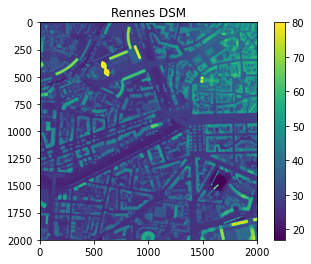

In [3]:
plt.imshow(dsm, vmax=80)
plt.colorbar()
plt.title('Rennes DSM')
plt.show()

## 1. Compute attributes and visualize the distrbution of values

- Compute the `area` and `compactness` attributes
- How can we visualize the distribution of values? Display the distribution of areas, then compactness.
    + Maybe what your are looking fore is already available in matplotlib package!

In [4]:
area = max_tree.get_attribute('area')
compactness = max_tree.get_attribute('compactness')

You can plot the distribution with histograms.

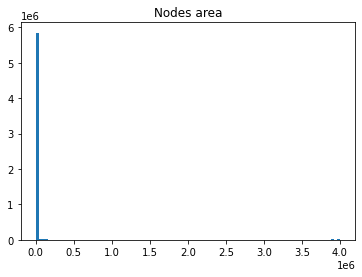

In [5]:
plt.hist(area, bins=100)
plt.title('Nodes area')
plt.show()

The number of nodes with area of 1 is so high that the plot is not very useful. We can remove the nodes with area of 1 from the histogram, or use a logarithmic scale on the y-axis. Here I choose the second solution.

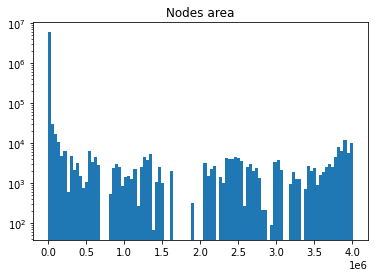

In [6]:
plt.hist(area, bins=100, log=True)
plt.title('Nodes area')
plt.show()

This is much better. One can observe that the areas are ranging from $1$ to $4 \times 1e6$ pixels (i.e. $0.5 m^2$ to $1 km^2$). That said, the structures we are interested in are rather small (trees, cars, houses...). We can set an upper threshold, or use a logaritmic scale on the x-axis. Again I choose the second solution. We need to compute the logarithmic bins first.

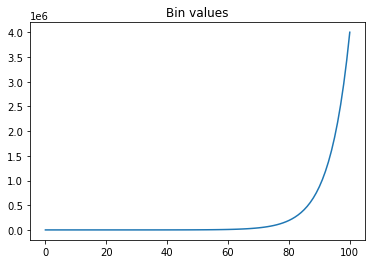

In [7]:
bins = np.geomspace(1, dsm.size, 100 + 1)
plt.plot(bins)
plt.title('Bin values')
plt.show()

An easy way is to use `geomspace` from numpy, it returns numbers spaced evenly on a log scale between a start and a stop values.

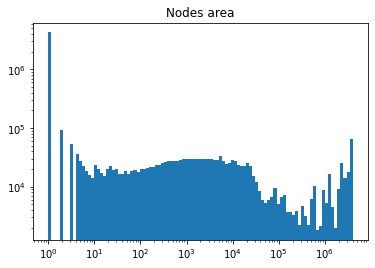

In [8]:
plt.hist(area, bins=bins, log=True)
plt.xscale('log')
plt.title('Nodes area')
plt.show()

The very small structures (the 3 first bins are for structures bellow $1m^2$) but at the same time the intermediate structures such as car and houses are well covered (structures between $10^2$ and $10^4$ pixels).

Now we can add the compactness histogram. I choose a linear scale to display the node compactness but you can also use logarithmic scale on the x-axis if you prefer.

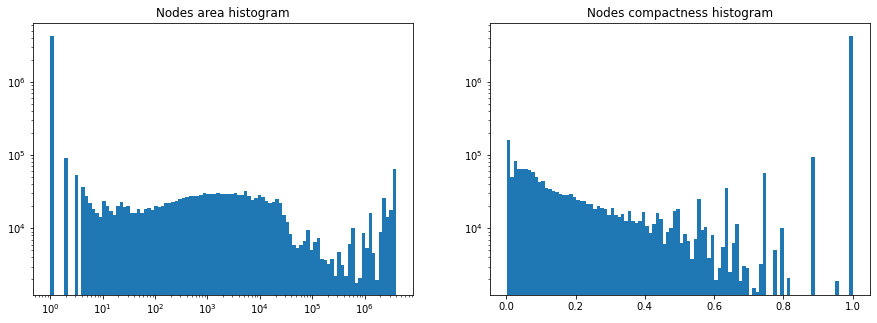

In [9]:
plt.figure(figsize=(15,5))

ax1 = plt.subplot(1,2,1)
plt.hist(area, bins=bins, log=True)
plt.xscale('log')
plt.title('Nodes area histogram')

plt.subplot(1,2,2, sharey=ax1)
plt.hist(compactness, bins=100, log=True)
plt.title('Nodes compactness histogram')

plt.show()

# 2. Compute a Pattern Spectrum

The pattern spectrum can be seen as nodes attributes probability distribution: for a given attribute value we display the probability to have nodes with these properties in the image.

To compute the Pattern Spectrum, you need to weight the histograms with the area of the flat zone times the height diffence of the flat zone and its direct ancester.

- Compute and display the Pattern Spectrum
    - For `area` attributes
    - For `compactness` attributes

We have to weights each nodes according to its area in order to obtain the probability to see the node in the image. To normalize the distributions we can set the weights by their relative size in the image rather than using directly a pixel count.

In [10]:
altitudes = max_tree._alt
parent_altitudes = altitudes[max_tree._tree.parents()]
delta_altitudes = altitudes - parent_altitudes

weights = area * delta_altitudes
weights

array([   0.        ,    0.        ,    0.        , ...,  397.11135864,
       3551.09284401,    0.        ])

And now we just have to set the `weights` parameter from the `hist` function with ours weights.

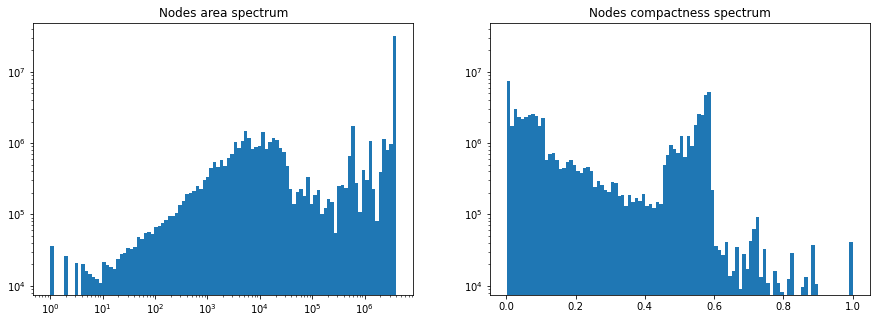

In [11]:
plt.figure(figsize=(15,5))

ax1 = plt.subplot(1,2,1)
plt.hist(area, bins=bins, log=True, weights=weights)
plt.xscale('log')
plt.title('Nodes area spectrum')

plt.subplot(1,2,2, sharey=ax1)
plt.hist(compactness, bins=100, log=True, weights=weights)
plt.title('Nodes compactness spectrum')

plt.show()

## 3. Compute and display a 2D Pattern Spectrum with SAP

- Compute a 2D PS with SAP
- Find objet of interrest in the spectrum
- Filter the DSM according to the object of interest in the spectum

In this part we display 2D histogram like plots.
2D histograms are similar to 1D histogram but with a variable on each axis (x and y), the count is displayed with a color scale.

2D spectrum is similar to a 2D histogram. For exemple, the 2D histogram of nodes area and compactness:

/tmp/ipykernel_57100/3762472443.py:1: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.hist2d(area, compactness, bins=(bins, 100), norm=mpl.colors.LogNorm(), vmax=10000)


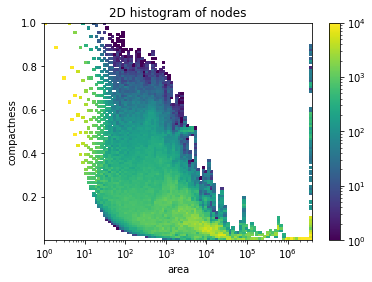

In [12]:
plt.hist2d(area, compactness, bins=(bins, 100), norm=mpl.colors.LogNorm(), vmax=10000)

plt.xlabel('area')
plt.xscale('log')
plt.ylabel('compactness')

plt.colorbar()

plt.title('2D histogram of nodes')
plt.show()

We just have to add the weights to obtain the patern spectrum of area and compactness.

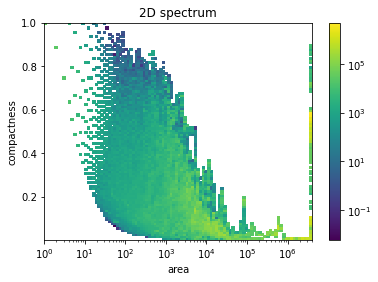

In [13]:
plt.hist2d(area, compactness, bins=(bins, 100), norm=mpl.colors.LogNorm(), weights=weights)

plt.xlabel('area')
plt.xscale('log')
plt.ylabel('compactness')

plt.colorbar()

plt.title('2D spectrum')
plt.show()

In the future you can use the ready-to-use function in SAP!

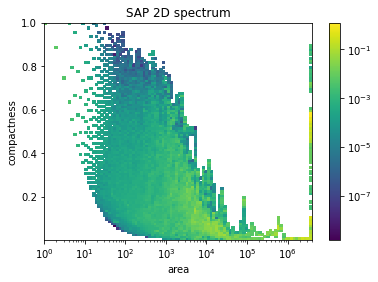

In [14]:
ps = sap.spectrum2d(max_tree, 'area', 'compactness', x_log=True)

sap.show_spectrum(*ps)
plt.xlabel('area')
plt.ylabel('compactness')
plt.colorbar()

plt.title('SAP 2D spectrum')
plt.show()

The spectrum is usefull to perform attribute filtering in the tree. We can use it to set thresholds on the attributes, here we set thresholds min and max on area and compactness according to the spectrum to highlight structures in the DSM.

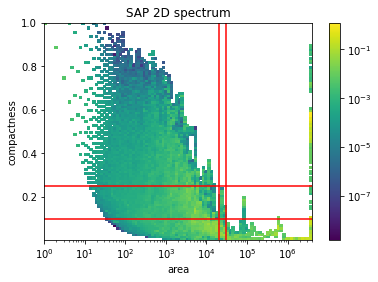

In [15]:
a_min = 2 * 10**4
a_max = 3 * 10**4

c_min = 0.10
c_max = 0.25

sap.show_spectrum(*ps)
plt.xlabel('area')
plt.ylabel('compactness')
plt.colorbar()

plt.vlines((a_min, a_max), *plt.ylim(), colors='red')
plt.hlines((c_min, c_max), *plt.xlim(), colors='red')

plt.title('SAP 2D spectrum')
plt.show()

The we compute the deleted node vector for the max-tree.

In [16]:
deleted_nodes_area = (area < a_min) | (area > a_max)
deleted_nodes_compactness = (compactness < c_min) | (compactness > c_max)

deleted_nodes_area, deleted_nodes_compactness

(array([ True,  True,  True, ...,  True,  True,  True]),
 array([ True,  True,  True, ...,  True,  True,  True]))

In [17]:
deleted_nodes = deleted_nodes_area | deleted_nodes_compactness

deleted_nodes.sum(), deleted_nodes.size - deleted_nodes.sum()

(6115099, 4534)

And reconstruct the tree.

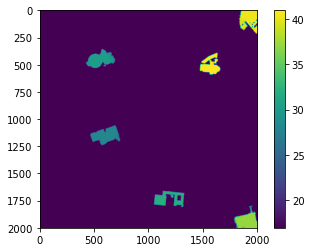

In [18]:
dsm_filtered = max_tree.reconstruct(deleted_nodes)

plt.imshow(dsm_filtered)
plt.colorbar()
plt.show()

Final figure.

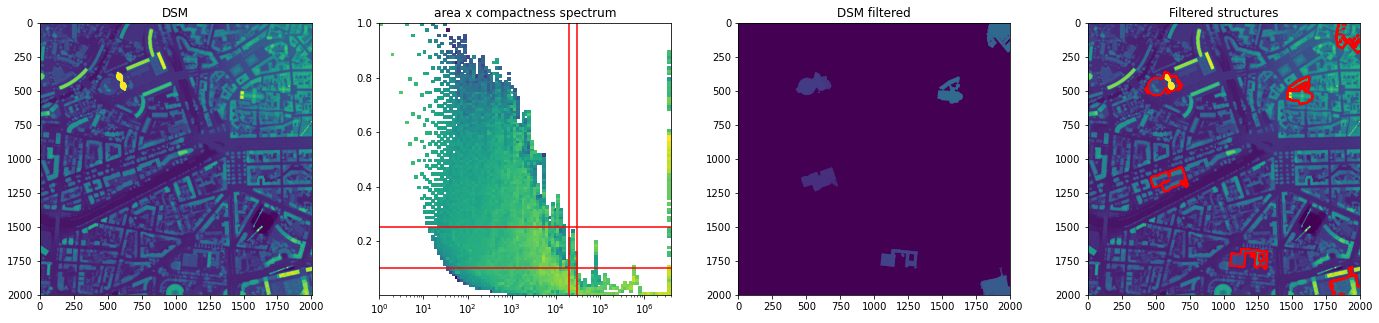

In [19]:
plt.figure(figsize=(24, 5))

plt.subplot(1,4,1)
plt.imshow(dsm, vmin=20, vmax=80)
plt.title('DSM')

plt.subplot(1,4,2)
sap.show_spectrum(*ps)
plt.vlines((a_min, a_max), *plt.ylim(), colors='red')
plt.hlines((c_min, c_max), *plt.xlim(), colors='red')
plt.title('area x compactness spectrum')

plt.subplot(1,4,3)
plt.imshow(dsm_filtered, vmin=20, vmax=80)
plt.title('DSM filtered')

plt.subplot(1,4,4)
plt.imshow(dsm, vmin=20, vmax=80)
plt.contour(dsm_filtered, colors='red')
plt.title('Filtered structures')

plt.show()